#### 大规模 Transformer 模型 8 比特量化矩阵乘简介 - 基于 Hugging Face Transformers、Accelerate 以及 bitsandbytes

blog https://hf-mirror.com/blog/hf-bitsandbytes-integration

[原理](imgs/Matmul.png) 
[paper]("./LLM_int8 2208.07339v2.pdf")

![原始矩阵](imgs/Mixed.png)

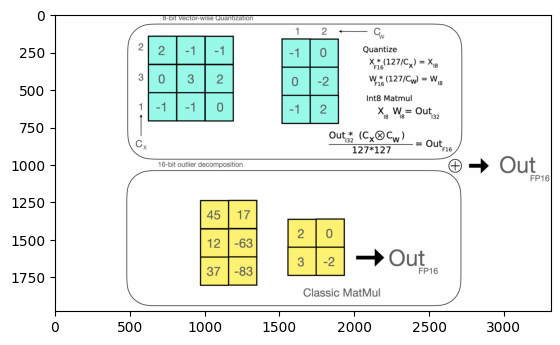

In [10]:


plt.imshow(plt.imread('imgs/Matmul.png'))

In [80]:
# 大规模 Transformer 模型 8 比特量化矩阵乘简介 - 基于 Hugging Face Transformers、Accelerate 以及 bitsandbytes
# blog https://hf-mirror.com/blog/hf-bitsandbytes-integration
import torch
# 如果不量化，直接相乘的结果
X_no_quant=torch.Tensor([
    # 其中的第1,3列有离群点，需要剔除
    [2, 45, -1, 17, -1],
	[0, 12, 3, -63, 2],
	[-1, 37, -1, -83, 0]
])

W_no_quant=torch.Tensor([
    # 因为x第1,3列有离群点，因此w篛1,3行需要剔除
    [-1, 0],
    [2, 0], # 原来剔除的行 
	[0, -2],
	[3, -2], # 原来剔除的行
    [-1, 2]])

In [64]:
# 对于非离群点，使用int8逐行逐列量化
X=torch.Tensor([[2, -1, -1],
	[0,3,2],
	[-1,-1,0]
])

W=torch.Tensor([[-1, 0],
	[0, -2],
    [-1, 2]])
Cx=X.abs().max(axis=1).values  # 找出每列的绝对值的最大值
Cw=W.abs().max(axis=0).values  # 找出每行的绝对值的最大值

X_i8=(X*(127/Cx.view(3,1))).to(torch.int8)
W_i8 =(W*(127/Cw.view(1,2))).to(torch.int8)

Out_i32=X_i8.to(torch.int32)@W_i8.to(torch.int32) # 可以看到对于int8量化，只是减小了内存，但并没有减小计算量 
Out_f16=Out_i32*(Cx.view(3,1)/127)*(Cw.view(1,2)/127) # 先对结果进行逐列的norm，再对结果进行逐行的norm

In [65]:
X_i8

tensor([[ 127,  -63,  -63],
        [   0,  127,   84],
        [-127, -127,    0]], dtype=torch.int8)

In [66]:
W_i8

tensor([[-127,    0],
        [   0, -127],
        [-127,  127]], dtype=torch.int8)

In [67]:
Out_i32

tensor([[ -8128,      0],
        [-10668,  -5461],
        [ 16129,  16129]], dtype=torch.int32)

In [68]:
Out_f16  # int8量化的结果

tensor([[-1.0079,  0.0000],
        [-1.9843, -2.0315],
        [ 1.0000,  2.0000]])

In [69]:
Out_origin=X@W # 原始float32的相乘结果，可以看到还是有一定的差距

In [70]:
Out_origin

tensor([[-1.,  0.],
        [-2., -2.],
        [ 1.,  2.]])

In [47]:
(Out_f16-Out_origin).std() # 标准差

tensor(0.0155)

In [54]:
# 对于离群点，还是使用原来的fp16进行计算
X_outlier= torch.Tensor([[47,17], [12, -63], [37, -83]])
W_outlier = torch.Tensor([[2, 0], [3, -2]])

In [62]:
Out_outlier_fp16=X_outlier@W_outlier
Out_quant_final = Out_f16 + Out_outlier_fp16 # 最终量化的

In [71]:
Out_f16, Out_outlier_fp16, Out_quant_final

(tensor([[-1.0079,  0.0000],
         [-1.9843, -2.0315],
         [ 1.0000,  2.0000]]),
 tensor([[ 145.,  -34.],
         [-165.,  126.],
         [-175.,  166.]]),
 tensor([[ 143.9921,  -34.0000],
         [-166.9843,  123.9685],
         [-174.0000,  168.0000]]))

In [58]:
# 如果不量化，直接相乘的结果
X_no_quant=torch.Tensor([
    # 其中的第1,3列有离群点，需要剔除
    [2, 45, -1, 17, -1],
	[0, 12, 3, -63, 2],
	[-1, 37, -1, -83, 0]
])

W_no_quant=torch.Tensor([
    # 因为x第1,3列有离群点，因此w篛1,3行需要剔除
    [-1, 0],
    [2, 0], # 原来剔除的行 
	[0, -2],
	[3, -2], # 原来剔除的行
    [-1, 2]])

In [60]:
Out_no_quant=X_no_quant@W_no_quant

In [79]:
Out_no_quant

tensor([[ 140.,  -34.],
        [-167.,  124.],
        [-174.,  168.]])

In [78]:
(Out_quant_final-Out_no_quant).std(), (Out_quant_final-Out_no_quant).std()/torch.max(X_no_quant[:])  # 误差绝对值
# 可见误差百分比很小

(tensor(1.6311), tensor(0.0362))